# Titanic - Machine Learning from Disaster

<img src="titanic_cover.jpeg" alt="HMS Titanic Sinking">

RMS Titanic was a British Passenger liner lauched on 31 May 1911 and was considered to be "unsinkable". It began it's maiden voyage 10 April 1912 from Southampton to New York City but owing to a crash with one of the icebergs in Atlantic Ocean it sank on 15 April 1912. The estimated death toll was over 1500 out of 2224 passengers and crew members abord making it the deadliest sinking of a single ship by that time. 

Kaggle has a competition names [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) which we have used here to perform Predictive Analytics on survival of passengers.  

## 0. Importing Libraries

In [1]:
# IMPORTING LIBRARIES
import csv
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import warnings
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

warnings.filterwarnings("ignore")
%matplotlib inline
random.seed(42)

## 1. Data Processing

### 1.1 Training Data

#### 1.1.1. Importing data from train.csv

In [2]:
train_csv_path = './train.csv'
parsed_train_data = []
with open(train_csv_path, mode='r', newline='', encoding='utf-8') as file:
    header = file.readline().strip().split(',')
    for line in file:
        values = []
        inside_quotes = False
        start = 0

        for i, char in enumerate(line):
            if char == '"':
                inside_quotes = not inside_quotes
            elif char == ',' and not inside_quotes:
                values.append(line[start:i])
                start = i + 1
        values.append(line[start:].strip())

        name_parts = values[3].replace('"', '').split()
        first_name = ' '.join(name_parts[1:])
        last_name = name_parts[0].replace(',', '')
        
        row = {
            'PassengerId': int(values[0]),
            'Survived': int(values[1]),
            'Pclass': int(values[2]),
            'FirstName': first_name,
            'LastName': last_name,
            'Sex': values[4],
            'Age': float(values[5]) if values[5] else None,
            'SibSp': int(values[6]),
            'Parch': int(values[7]),
            'Ticket': values[8],
            'Fare': float(values[9]) if values[9] else None,
            'Cabin': values[10] if len(values) > 10 else None,
            'Embarked': values[11].strip() if len(values) > 11 else None
        }
        parsed_train_data.append(row)

#### 1.1.2. Normalizing Training Database

After parsing the data from `train.csv`, we constructed four tables to store various informations which is described below.
1. **Passenger** - This table stores the basic information of passengers, i.e., `Passenger ID`, `Name`, `Sex`(Gender), and `Age`.
2. **Ticket** - This table stores the information of all the tickets purchased by passengers. The columns are `Ticket`, `Fare`, `Cabin`, and `Embarked`
3. **TravelDetails** - This table stores travel centered information for all passengers by populating the columns `PassengerID`, `Ticket`, `Pclass`, `SibSp` (number of sibling/spouces), and `Parch` (number of parents/children)
4. **Survival** - This table stores the survival information of each passenger ater the disaster by polulating `PassengerID` and `Survived`. 

In [3]:
conn = sqlite3.connect('./titanic_normalized_train.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS Passenger (
    PassengerId INTEGER PRIMARY KEY,
    FirstName TEXT,
    LastName TEXT,
    Sex TEXT,
    Age REAL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Ticket (
    Ticket TEXT PRIMARY KEY,
    Fare REAL,
    Cabin TEXT,
    Embarked TEXT
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS TravelDetails (
    PassengerId INTEGER,
    Ticket TEXT,
    Pclass INTEGER,
    SibSp INTEGER,
    Parch INTEGER,
    FOREIGN KEY (PassengerId) REFERENCES Passenger (PassengerId),
    FOREIGN KEY (Ticket) REFERENCES Ticket (Ticket),
    PRIMARY KEY (PassengerId, Ticket)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Survival (
    PassengerId INTEGER PRIMARY KEY,
    Survived INTEGER,
    FOREIGN KEY (PassengerId) REFERENCES Passenger (PassengerId)
);
''')


cursor.execute('CREATE INDEX IF NOT EXISTS idx_sex ON Passenger (Sex);')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_embarked ON Ticket (Embarked);')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_survived ON Survival (Survived);')


for row in parsed_train_data:
    cursor.execute('''
    INSERT OR IGNORE INTO Passenger (PassengerId, FirstName, LastName, Sex, Age)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['PassengerId'], row['FirstName'], row['LastName'], row['Sex'], row['Age']))
    
    cursor.execute('''
    INSERT OR IGNORE INTO Ticket (Ticket, Fare, Cabin, Embarked)
    VALUES (?, ?, ?, ?)
    ''', (row['Ticket'], row['Fare'], row['Cabin'], row['Embarked']))
    
    cursor.execute('''
    INSERT OR IGNORE INTO TravelDetails (PassengerId, Ticket, Pclass, SibSp, Parch)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['PassengerId'], row['Ticket'], row['Pclass'], row['SibSp'], row['Parch']))

    cursor.execute('''
    INSERT OR IGNORE INTO Survival (PassengerId, Survived)
    VALUES (?, ?)
    ''', (row['PassengerId'], row['Survived']))

conn.commit()
conn.close()

### 1.2. Test Data

#### 1.2.1. Importing data from test.csv

In [4]:
test_csv_path = './test.csv'
parsed_test_data = []
with open(test_csv_path, mode='r', newline='', encoding='utf-8') as file:
    header = file.readline().strip().split(',')
    for line in file:
        values = []
        inside_quotes = False
        start = 0
        for i, char in enumerate(line):
            if char == '"':
                inside_quotes = not inside_quotes
            elif char == ',' and not inside_quotes:
                values.append(line[start:i])
                start = i + 1
        values.append(line[start:].strip())

        name_parts = values[2].replace('"', '').split()
        first_name = ' '.join(name_parts[1:])
        last_name = name_parts[0].replace(',', '')
        
        row = {
            'PassengerId': int(values[0]),
            'Pclass': int(values[1]),
            'FirstName': first_name,
            'LastName': last_name,
            'Sex': values[3],
            'Age': float(values[4]) if values[4] else None,
            'SibSp': int(values[5]),
            'Parch': int(values[6]),
            'Ticket': values[7],
            'Fare': float(values[8]) if values[8] else None,
            'Cabin': values[9] if len(values) > 9 else None,
            'Embarked': values[10].strip() if len(values) > 10 else None
        }
        parsed_test_data.append(row)

#### 1.2.1. Normalizing Test Database

After parsing the data from `test.csv`, we constructed four tables to store various informations which is described below.
1. **Passenger** - This table stores the basic information of passengers, i.e., `Passenger ID`, `Name`, `Sex`(Gender), and `Age`.
2. **Ticket** - This table stores the information of all the tickets purchased by passengers. The columns are `Ticket`, `Fare`, `Cabin`, and `Embarked`
3. **TravelDetails** - This table stores travel centered information for all passengers by populating the columns `PassengerID`, `Ticket`, `Pclass`, `SibSp` (number of sibling/spouces), and `Parch` (number of parents/children)

The Kaggle competition doesnot supply us with the survival information of passengers in the test set and so we only make 3 tables here instead of 4 tables in `titanic_normaized_train.db`. 

In [5]:
conn = sqlite3.connect('./titanic_normalized_test.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS Passenger (
    PassengerId INTEGER PRIMARY KEY,
    FirstName TEXT,
    LastName TEXT,
    Sex TEXT,
    Age REAL
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Ticket (
    Ticket TEXT PRIMARY KEY,
    Fare REAL,
    Cabin TEXT,
    Embarked TEXT
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS TravelDetails (
    PassengerId INTEGER,
    Ticket TEXT,
    Pclass INTEGER,
    SibSp INTEGER,
    Parch INTEGER,
    FOREIGN KEY (PassengerId) REFERENCES Passenger (PassengerId),
    FOREIGN KEY (Ticket) REFERENCES Ticket (Ticket),
    PRIMARY KEY (PassengerId, Ticket)
);
''')

cursor.execute('CREATE INDEX IF NOT EXISTS idx_sex ON Passenger (Sex);')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_embarked ON Ticket (Embarked);')

for row in parsed_test_data:
    cursor.execute('''
    INSERT OR IGNORE INTO Passenger (PassengerId, FirstName, LastName, Sex, Age)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['PassengerId'], row['FirstName'], row['LastName'], row['Sex'], row['Age']))
    
    cursor.execute('''
    INSERT OR IGNORE INTO Ticket (Ticket, Fare, Cabin, Embarked)
    VALUES (?, ?, ?, ?)
    ''', (row['Ticket'], row['Fare'], row['Cabin'], row['Embarked']))
    
    cursor.execute('''
    INSERT OR IGNORE INTO TravelDetails (PassengerId, Ticket, Pclass, SibSp, Parch)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['PassengerId'], row['Ticket'], row['Pclass'], row['SibSp'], row['Parch']))

conn.commit()
conn.close()

## 2. Data Analysis of Survival Rate

### 2.1. Analysis based on Gender

As we observed in the motion picture `Titanic`, the main priority of filling the rescue boats was "women and children first" we begin our data analysis by analysing survival rate on the basis of `Gender`. 

Total rows:  891
Count of dead males:  468
Count of survived males:  109
Count of dead females:  81
Count of survived females:  233
Count of total dead passengers:  549
Count of total survived passengers:  342


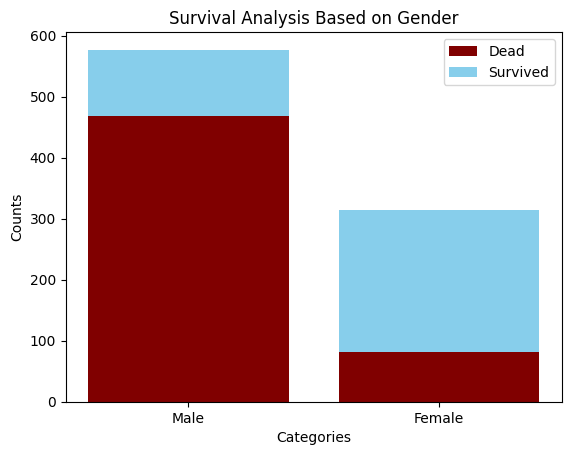

In [6]:
db_path = './titanic_normalized_train.db'
conn = sqlite3.connect(db_path) 
cursor = conn.cursor()
cursor.execute('SELECT Passenger.Sex, Survival.Survived FROM Passenger JOIN Survival ON Passenger.PassengerId = Survival.PassengerId;')
rows = cursor.fetchall()
result_set = pd.DataFrame(rows, columns=['Sex', 'Survived'])

count_of_dead_males = result_set[(result_set['Sex'] == 'male') & (result_set['Survived'] == 0)].shape[0]
count_of_survived_males = result_set[(result_set['Sex'] == 'male') & (result_set['Survived'] == 1)].shape[0]
count_of_dead_females = result_set[(result_set['Sex'] == 'female') & (result_set['Survived'] == 0)].shape[0]
count_of_survived_females = result_set[(result_set['Sex'] == 'female') & (result_set['Survived'] == 1)].shape[0]
count_of_dead_passengers = result_set[result_set['Survived'] == 0].shape[0]
count_of_survived_passengers = result_set[result_set['Survived'] == 1].shape[0]
total_rows = len(result_set)

# PRINT VALUES
print("Total rows: ", total_rows)
print("Count of dead males: ", count_of_dead_males)
print("Count of survived males: ", count_of_survived_males)
print("Count of dead females: ", count_of_dead_females)
print("Count of survived females: ", count_of_survived_females)
print("Count of total dead passengers: ", count_of_dead_passengers)
print("Count of total survived passengers: ", count_of_survived_passengers)

# PLOTS
categories = ['Dead Males', 'Survived Males', 'Dead Females', 'Survived Females']
counts = [count_of_dead_males, count_of_survived_males, count_of_dead_females, count_of_survived_females]
fig, ax = plt.subplots()
ax.bar(['Male', 'Female'], [count_of_dead_males, count_of_dead_females], label='Dead', color='maroon')
ax.bar(['Male', 'Female'], [count_of_survived_males, count_of_survived_females], bottom=[count_of_dead_males, count_of_dead_females], label='Survived', color='skyblue')
ax.set_title('Survival Analysis Based on Gender')
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.legend()
fig.savefig('./plots/Gender Data Analysis')
plt.show()

### 2.2. Analysis based on Age Groups

As the biggest focus was on saving the children on te ship, we performed Data Analysis to `Age` to get a fair idea of the survival rate. The Data Analysis was performed by making age categories as follows:
1. < 5 years 
2. 6 - 12 years
3. 13 - 18 years
4. 19 - 25 years
5. 26 - 35 years
6. 36 - 50 years
7. 51 - 70 years
8. 71+ years

Total rows:  891
Count of dead passengers by age category: 
AgeCategory
0-5       13
6-12      16
13-18     23
19-25    108
26-35    123
36-50     94
51-70     41
71+        6
Name: count, dtype: int64
Count of survived passengers by age category: 
AgeCategory
0-5      27
6-12     12
13-18    22
19-25    57
26-35    78
36-50    67
51-70    26
71+       1
Name: count, dtype: int64


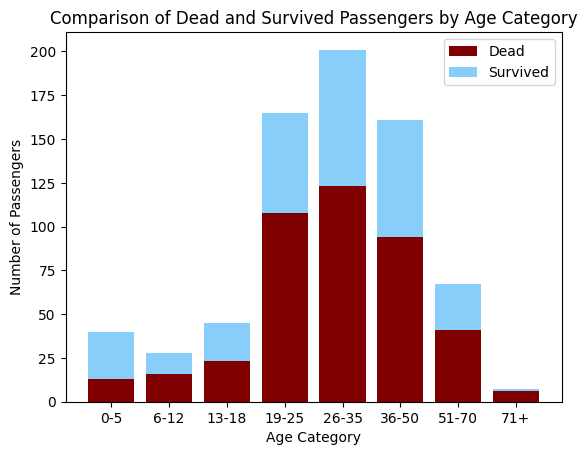

In [7]:
db_path = './titanic_normalized_train.db'
conn = sqlite3.connect(db_path) 
cursor = conn.cursor()
cursor.execute('SELECT Passenger.Age, Survival.Survived FROM Passenger JOIN Survival ON Passenger.PassengerId = Survival.PassengerId;')
rows = cursor.fetchall()
result_set = pd.DataFrame(rows, columns=['Age', 'Survived'])
bins = [0, 5, 12, 18, 25, 35, 50, 70, 100]
labels = ['0-5', '6-12', '13-18', '19-25', '26-35', '36-50', '51-70', '71+']
result_set['AgeCategory'] = pd.cut(result_set['Age'], bins=bins, labels=labels, right=False)

count_of_dead_by_age_category = result_set[result_set['Survived'] == 0]['AgeCategory'].value_counts().sort_index()
count_of_survived_by_age_category = result_set[result_set['Survived'] == 1]['AgeCategory'].value_counts().sort_index()
total_rows = len(result_set)

# PRTINING VALUES
print("Total rows: ", total_rows)
print("Count of dead passengers by age category: ")
print(count_of_dead_by_age_category)
print("Count of survived passengers by age category: ")
print(count_of_survived_by_age_category)

conn.close()

# PLOTS
fig, ax = plt.subplots()
ax.bar(count_of_dead_by_age_category.index, count_of_dead_by_age_category, label='Dead', color='maroon')
ax.bar(count_of_survived_by_age_category.index, count_of_survived_by_age_category, bottom=count_of_dead_by_age_category, label='Survived', color='lightskyblue')
ax.set_xlabel('Age Category')
ax.set_ylabel('Number of Passengers')
ax.set_title('Comparison of Dead and Survived Passengers by Age Category')
ax.legend()
fig.savefig('./plots/Age Data Analysis')
plt.show()

## 3. Model Training

### 3.1. Data Preparation

Based on the information available we decided to build ML models based on the followng 6 features:
1. `Pclass` - As the passenger class is based on the ticket fares we used this features to incorparate possiblilities of corruption into our model training process.
2. `SibSp` - The chances of survival can increase with more relatives (due to better directionality in scenes of choas), so we included this into our model.
3. `ParCh` - The chances of survival can be affected by the presence of parents ad childern so we have included this into our models.
4. `Embarked` - This is merely a precautionary feature included to incorporate possible sense of community based on port of embarkment (C - Cherbourg, Q - Queenstown, S - Southampton)
5. `Sex` - Since we've already discussed that gender was one of the primary factors of decision making we've used this feature.
6. `Age` - Like gender, age was also one of the primary basis of decision making we've used this feature as well.

Since we donot have a test set with target variable available, we split our training data into a `Train` set and `Validation` set with 90-10 split to obtain 801 and 90 datapoints respectively.

#### 3.1.1. Training Data

In [8]:
db_path = './titanic_normalized_train.db'
conn = sqlite3.connect(db_path) 
cursor = conn.cursor()

sql_statement = '''
    SELECT *, s.*
    FROM (
        SELECT *, p.*
        FROM (
            SELECT td.*, t.*
            FROM TravelDetails td
            INNER JOIN Ticket t ON td.Ticket = t.Ticket
        ) AS combined_table
        INNER JOIN Passenger p ON combined_table.PassengerID = p.PassengerID
    ) AS final_table
    INNER JOIN Survival s ON final_table.PassengerID = s.PassengerID
'''
cursor.execute(sql_statement)
rows = cursor.fetchall()
df_train = pd.DataFrame(rows)

In [9]:
df_train.drop(columns={1,5,6,7,9,10,11,12,13,14,15,16,19,21,22}, inplace=True)
df_train.rename(columns={0:"PassengerID", 2:"Pclass", 3:"SibSp", 4:"ParCh", 8:"Embarked", 17:"Sex", 18:"Age", 20:"Survived"}, inplace=True)
bins = [0, 1, 5, 12, 18, 25, 35, 50, 70, 100]
df_train["Age"].fillna(method='ffill', inplace=True)
df_train['Age'] = pd.cut(df_train['Age'], bins=bins, labels=range(1, len(bins)), right=False)
df_train['Sex'] = df_train['Sex'].replace({"male":0, "female":1})
df_train['Embarked'] = df_train['Embarked'].replace({"C":1,"Q":2,"S":3, "":0})
df_train.head()

,PassengerID,Pclass,SibSp,ParCh,Embarked,Sex,Age,Survived
0,1,3,1,0,3,0,5,0
1,2,1,1,0,1,1,7,1
2,3,3,0,0,3,1,6,1
3,4,1,1,0,3,1,7,1
4,5,3,0,0,3,0,7,0


#### 3.1.2. Test Data

In [10]:
db_path = './titanic_normalized_test.db'
conn = sqlite3.connect(db_path) 
cursor = conn.cursor()
sql_statement = '''
    SELECT *, p.*
        FROM (
            SELECT td.*, t.*
            FROM TravelDetails td
            INNER JOIN Ticket t ON td.Ticket = t.Ticket
        ) AS combined_table
    INNER JOIN Passenger p ON combined_table.PassengerID = p.PassengerID
'''
cursor.execute(sql_statement)
rows = cursor.fetchall()
df_test = pd.DataFrame(rows)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,892,330911,3,0,0,330911,7.8292,,Q,892,Mr. James,Kelly,male,34.5,892,Mr. James,Kelly,male,34.5
1,893,363272,3,1,0,363272,7.0000,,S,893,Mrs. James (Ellen Needs),Wilkes,female,47.0,893,Mrs. James (Ellen Needs),Wilkes,female,47.0
2,894,240276,2,0,0,240276,9.6875,,Q,894,Mr. Thomas Francis,Myles,male,62.0,894,Mr. Thomas Francis,Myles,male,62.0
3,895,315154,3,0,0,315154,8.6625,,S,895,Mr. Albert,Wirz,male,27.0,895,Mr. Albert,Wirz,male,27.0
4,896,3101298,3,1,1,3101298,12.2875,,S,896,Mrs. Alexander (Helga E Lindqvist),Hirvonen,female,22.0,896,Mrs. Alexander (Helga E Lindqvist),Hirvonen,female,22.0


In [11]:
df_test.drop(columns={1,5,6,7,9,10,11,12,13,14,15,16}, inplace=True)
df_test.rename(columns={0:"PassengerID", 2:"Pclass", 3:"SibSp", 4:"ParCh", 8:"Embarked", 17:"Sex", 18:"Age"}, inplace=True)
bins = [0, 1, 5, 12, 18, 25, 35, 50, 70, 100]
df_test["Age"].fillna(method='ffill', inplace=True)
df_test['Age'] = pd.cut(df_test['Age'], bins=bins, labels=range(1, len(bins)), right=False)
df_test['Sex'] = df_test['Sex'].replace({"male":0, "female":1})
df_test['Embarked'] = df_test['Embarked'].replace({"C":1,"Q":2,"S":3,"":0})
df_test.head()

,PassengerID,Pclass,SibSp,ParCh,Embarked,Sex,Age
0,892,3,0,0,2,0,6
1,893,3,1,0,3,1,7
2,894,2,0,0,2,0,8
3,895,3,0,0,3,0,6
4,896,3,1,1,3,1,5


### 3.2. Model Training

Based on the selected we trained 5 ML models:
1. Logistic Regression
2. Support Vector Classifier
3. Decision Tree Classifier
4. K-Nearest Neighbors Classifier
5. Random Forest Classifier

We selected these 5 models because they perform very well with small number of training datapoints which is 801 datapoinys in our case. 

In [12]:
Y = df_train["Survived"]
X = df_train[["Pclass", "SibSp", "ParCh", "Embarked", "Sex", "Age"]]
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)

#### 3.2.1. Logistic Regression

In [13]:
model1 = LogisticRegression()
model1.fit(x_train, y_train)
score1 = model1.score(x_val, y_val)
print(f"Training accuracy of Logistic Regression = {round(score1,4)*100}%")

Training accuracy of Logistic Regression = 77.78%


In [14]:
y_pred1 = model1.predict(x_val)
[acc_score1, conf_mat1, f11, pres1, rec1] = [accuracy_score(y_val, y_pred1), confusion_matrix(y_val, y_pred1), f1_score(y_val, y_pred1), precision_score(y_val, y_pred1), recall_score(y_val, y_pred1)]
print(f"Logistic Regression Metrices:\n{conf_mat1}\nAccuracy: {acc_score1}%\nPrecision Score: {pres1}\nRecall Score: {rec1}\nF1 Score: {f11}")

Logistic Regression Metrices:
[[43 14]
 [ 6 27]]
Accuracy: 0.7777777777777778%
Precision Score: 0.6585365853658537
Recall Score: 0.8181818181818182
F1 Score: 0.7297297297297297


#### 3.2.2. Support Vector Classifier

In [15]:
model2 = SVC()
model2.fit(x_train, y_train)
score2 = model2.score(x_val, y_val)
print(f"Training accuracy of Support Vector Classifier = {round(score2,4)*100}%")

Training accuracy of Support Vector Classifier = 84.44%


In [16]:
y_pred2 = model2.predict(x_val)
[acc_score2, conf_mat2, f12, pres2, rec2] = [accuracy_score(y_val, y_pred2), confusion_matrix(y_val, y_pred2), f1_score(y_val, y_pred2), precision_score(y_val, y_pred2), recall_score(y_val, y_pred2)]
print(f"Support Vector Classification Metrices:\n{conf_mat2}\nAccuracy: {acc_score2}\nPrecision Score: {pres2}\nRecall Score: {rec2}\nF1 Score: {f12}")

Support Vector Classification Metrices:
[[47 10]
 [ 4 29]]
Accuracy: 0.8444444444444444
Precision Score: 0.7435897435897436
Recall Score: 0.8787878787878788
F1 Score: 0.8055555555555556


#### 3.2.3. Decision Tree Classifier

In [17]:
model3 = DecisionTreeClassifier()
model3.fit(x_train, y_train)
score3 = model3.score(x_val, y_val)
print(f"Training accuracy of Decision Tree Classifier = {round(score3,4)*100}%")

Training accuracy of Decision Tree Classifier = 80.0%


In [18]:
y_pred3 = model3.predict(x_val)
[acc_score3, conf_mat3, f13, pres3, rec3] = [accuracy_score(y_val, y_pred3), confusion_matrix(y_val, y_pred3), f1_score(y_val, y_pred3), precision_score(y_val, y_pred3), recall_score(y_val, y_pred3)]
print(f"Decision Tree Classification Metrices:\n{conf_mat3}\nAccuracy: {acc_score3}\nPrecision Score: {pres3}\nRecall Score: {rec3}\nF1 Score: {f13}")

Decision Tree Classification Metrices:
[[49  8]
 [10 23]]
Accuracy: 0.8
Precision Score: 0.7419354838709677
Recall Score: 0.696969696969697
F1 Score: 0.71875


#### 3.2.4. K-Nearest Neighbors Classifier

In [19]:
model4 = KNeighborsClassifier()
model4.fit(x_train, y_train)
score4 = model4.score(x_val, y_val)
print(f"Training accuracy of K-Nearest Neighbors Classifier = {round(score4,4)*100}%")

Training accuracy of K-Nearest Neighbors Classifier = 82.22%


In [20]:
y_pred4 = model4.predict(x_val)
[acc_score4, conf_mat4, f14, pres4, rec4] = [accuracy_score(y_val, y_pred4), confusion_matrix(y_val, y_pred4), f1_score(y_val, y_pred4), precision_score(y_val, y_pred4), recall_score(y_val, y_pred4)]
print(f"KNN Classifier Metrices:\n{conf_mat4}\nAccuracy: {acc_score4}\nPrecision Score: {pres4}\nRecall Score: {rec4}\nF1 Score: {f14}")

KNN Classifier Metrices:
[[50  7]
 [ 9 24]]
Accuracy: 0.8222222222222222
Precision Score: 0.7741935483870968
Recall Score: 0.7272727272727273
F1 Score: 0.7500000000000001


#### 3.2.5. Random Forest Classifier

In [21]:
model5 = RandomForestClassifier()
model5.fit(x_train, y_train)
score5 = model5.score(x_val, y_val)
print(f"Training accuracy of Random Forest Classifier = {round(score5,4)*100}%")

Training accuracy of Random Forest Classifier = 81.11%


In [22]:
y_pred5 = model5.predict(x_val)
[acc_score5, conf_mat5, f15, pres5, rec5] = [accuracy_score(y_val, y_pred5), confusion_matrix(y_val, y_pred5), f1_score(y_val, y_pred5), precision_score(y_val, y_pred5), recall_score(y_val, y_pred5)]
print(f"Random Forest Classification Metrices:\n{conf_mat5}\nAccuracy: {acc_score5}\nPrecision Score: {pres5}\nRecall Score: {rec5}\nF1 Score: {f15}")

Random Forest Classification Metrices:
[[48  9]
 [ 8 25]]
Accuracy: 0.8111111111111111
Precision Score: 0.7352941176470589
Recall Score: 0.7575757575757576
F1 Score: 0.746268656716418


#### 3.2.6. Saving Trained Models and Results

In [23]:
results = {
    "Model": ["Logistic Regression", "Support Vector Classifier", "Decision Tree Classifier", "KNN Classifier", "Random Forest Classifier"],
    "Accuracy": [acc_score1, acc_score2, acc_score3, acc_score4, acc_score5],
    "Precision": [pres1, pres2, pres3, pres4, pres5],
    "Recall": [rec1, rec2, rec3, rec4, rec5],
    "F1-Score": [f11, f12, f13, f14, f15]
}
df_results = pd.DataFrame(results)
df_results.to_csv('./predictions/Results.csv', index=False)
df_results.head(5)

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.777778,0.658537,0.818182,0.729730
1,Support Vector Classifier,0.844444,0.743590,0.878788,0.805556
2,Decision Tree Classifier,0.800000,0.741935,0.696970,0.718750
3,KNN Classifier,0.822222,0.774194,0.727273,0.750000
4,Random Forest Classifier,0.811111,0.735294,0.757576,0.746269


In [24]:
[fname1, fname2, fname3, fname4, fname5] = ['./models/log_reg_model.sav', './models/svc_model.sav', './models/dec_tree_model.sav', './models/knn_model.sav', './models/ran_for_model.sav']
pickle.dump(model1, open(fname1, 'wb'))
pickle.dump(model2, open(fname2, 'wb'))
pickle.dump(model3, open(fname3, 'wb'))
pickle.dump(model4, open(fname4, 'wb'))
pickle.dump(model5, open(fname5, 'wb'))

### 3.3. Predicting Survival on Test Data

Since the actual test dataset is used to score submission on the Kaggle competition we've used predictions from all the 5 models to chech their performances on the test set. The results are as follows:

| Models                            | Validation Accuracy | Test Accuracy |
| :-------------------------------- | :-----------------: | :-----------: |
| 1. Logistic Regression            | 76.67%              | 75.59%        |
| 2. Support Vector Classifier      | 81.11%              | 71.05%        |  
| 3. Decision Tree Classifier       | 75.56%              | 74.4%         |
| 4. K-Nearest Neighbors Classifier | 80%                 | 77.99%        |
| 5. Random Forest Classifier       | 77.78%              | 76.55%        |

#### 3.3.1. Making Predictions

In [25]:
[preds1, preds2, preds3, preds4, preds5] = [[], [], [], [], []]
for _ in range(df_test.shape[0]):
    sam = np.array(df_test[["Pclass", "SibSp", "ParCh", "Embarked", "Sex", "Age"]].iloc[_])
    sam = sam.reshape(1,-1)
    p1 = model1.predict(sam)
    p2 = model2.predict(sam)
    p3 = model3.predict(sam)
    p4 = model4.predict(sam)
    p5 = model5.predict(sam)
    preds1.append(p1[0])
    preds2.append(p2[0])
    preds3.append(p3[0])
    preds4.append(p4[0])
    preds5.append(p5[0])
df_test["Preds1"] = preds1
df_test["Preds2"] = preds2
df_test["Preds3"] = preds3
df_test["Preds4"] = preds4
df_test["Preds5"] = preds5

#### 3.3.2. Saving Predictions

In [26]:
df_pred1 = df_test[["PassengerID", "Preds1"]]
df_pred2 = df_test[["PassengerID", "Preds2"]]
df_pred3 = df_test[["PassengerID", "Preds3"]]
df_pred4 = df_test[["PassengerID", "Preds4"]]
df_pred5 = df_test[["PassengerID", "Preds5"]]

In [27]:
df_pred1.rename(columns={"Preds1":"Survived"}, inplace=True)
df_pred2.rename(columns={"Preds2":"Survived"}, inplace=True)
df_pred3.rename(columns={"Preds3":"Survived"}, inplace=True)
df_pred4.rename(columns={"Preds4":"Survived"}, inplace=True)
df_pred5.rename(columns={"Preds5":"Survived"}, inplace=True)

In [28]:
df_pred1.to_csv("./predictions/LogisticReg.csv", index=False)
df_pred2.to_csv("./predictions/SVC.csv", index=False)
df_pred3.to_csv("./predictions/DecisionTree.csv", index=False)
df_pred4.to_csv("./predictions/KNNClassifier.csv", index=False)
df_pred5.to_csv("./predictions/RandomForest.csv", index=False)

#### 3.3.3. Test Results (Kaggle Competition)

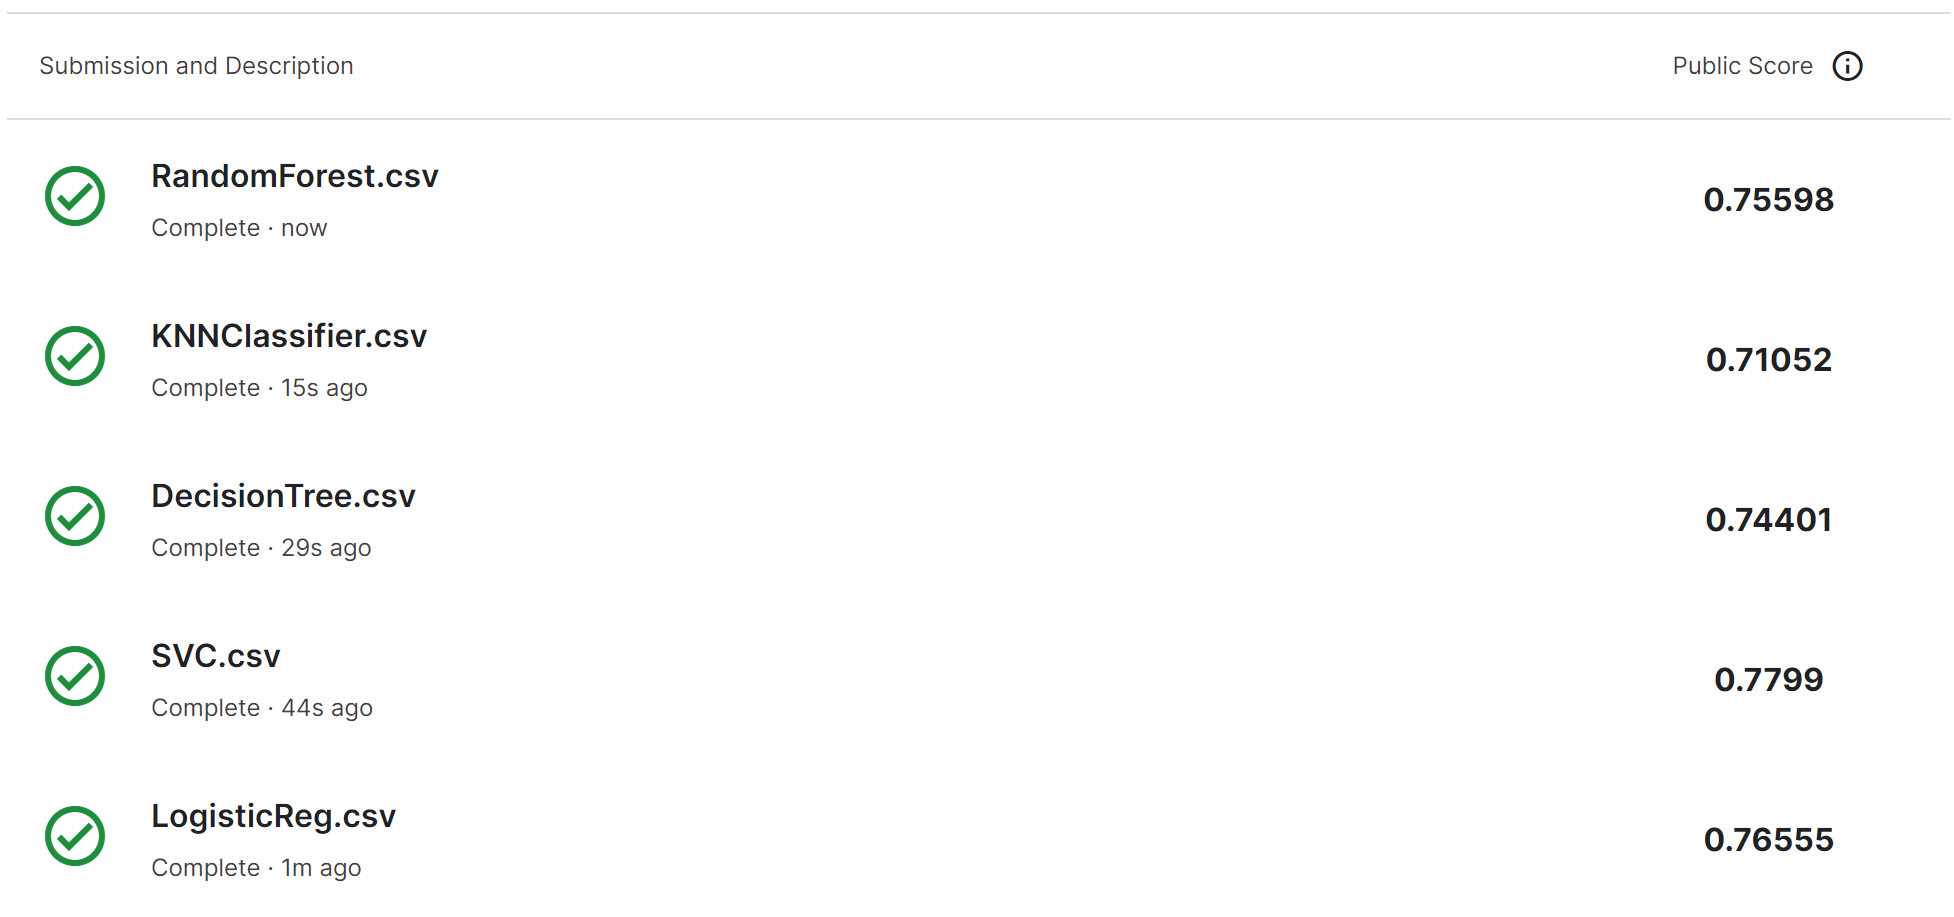

In [29]:
display.Image("./Test Set Results.png")

## 4. Analyzing and Comparing Model Performances

### 4.1. Age Analysis

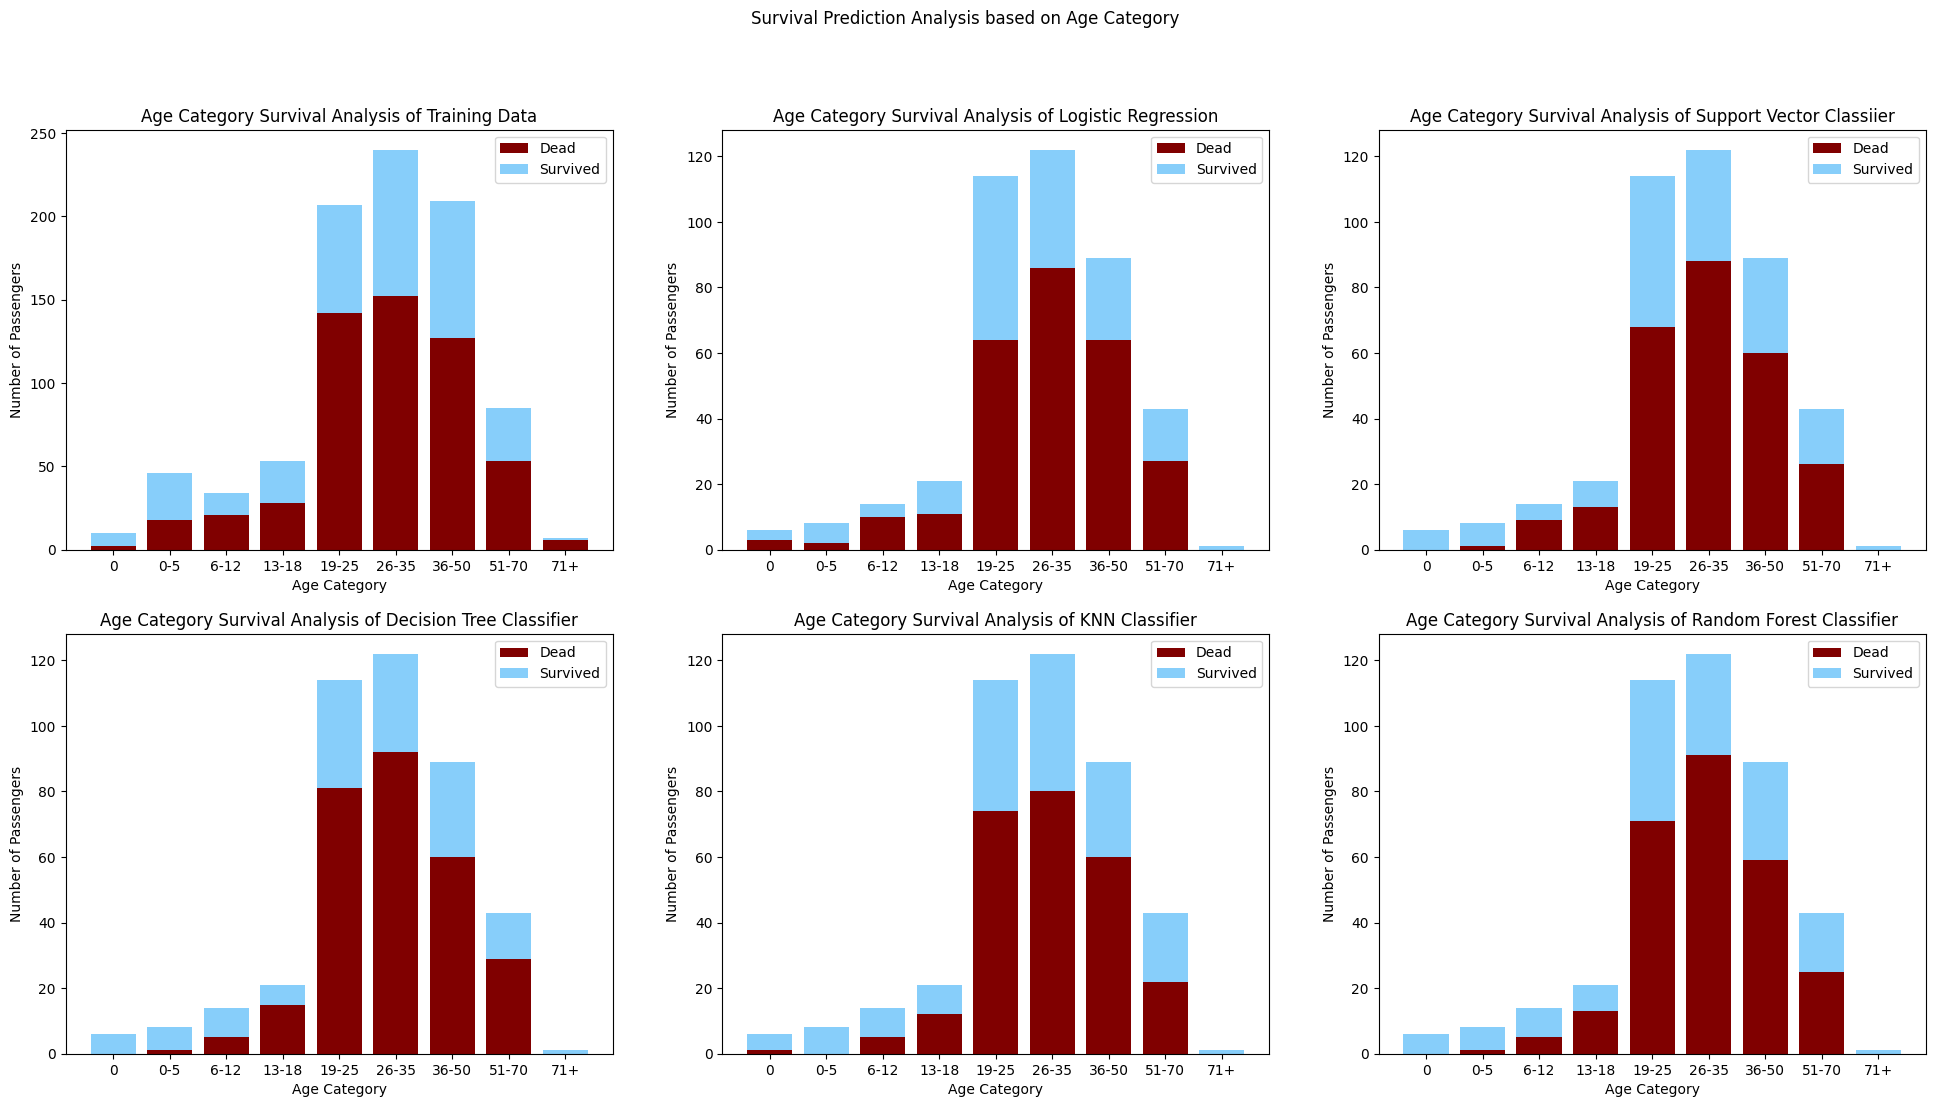

In [30]:
labels = ['0','0-5', '6-12', '13-18', '19-25', '26-35', '36-50', '51-70', '71+']
fig, ax = plt.subplots(2,3, figsize=(24,12))

ax[0,0].bar(labels, df_train[df_train['Survived'] == 0]['Age'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,0].bar(labels, df_train[df_train['Survived'] == 1]['Age'].value_counts().sort_index(), bottom=df_train[df_train['Survived'] == 0]['Age'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,0].set_xlabel('Age Category')
ax[0,0].set_ylabel('Number of Passengers')
ax[0,0].set_title('Age Category Survival Analysis of Training Data')
ax[0,0].legend()

ax[0,1].bar(labels, df_test[df_test['Preds1'] == 0]['Age'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,1].bar(labels, df_test[df_test['Preds1'] == 1]['Age'].value_counts().sort_index(), bottom=df_test[df_test['Preds1'] == 0]['Age'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,1].set_xlabel('Age Category')
ax[0,1].set_ylabel('Number of Passengers')
ax[0,1].set_title('Age Category Survival Analysis of Logistic Regression')
ax[0,1].legend()

ax[0,2].bar(labels, df_test[df_test['Preds2'] == 0]['Age'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,2].bar(labels, df_test[df_test['Preds2'] == 1]['Age'].value_counts().sort_index(), bottom=df_test[df_test['Preds2'] == 0]['Age'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,2].set_xlabel('Age Category')
ax[0,2].set_ylabel('Number of Passengers')
ax[0,2].set_title('Age Category Survival Analysis of Support Vector Classiier')
ax[0,2].legend()

ax[1,0].bar(labels, df_test[df_test['Preds3'] == 0]['Age'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,0].bar(labels, df_test[df_test['Preds3'] == 1]['Age'].value_counts().sort_index(), bottom=df_test[df_test['Preds3'] == 0]['Age'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,0].set_xlabel('Age Category')
ax[1,0].set_ylabel('Number of Passengers')
ax[1,0].set_title('Age Category Survival Analysis of Decision Tree Classifier')
ax[1,0].legend()

ax[1,1].bar(labels, df_test[df_test['Preds4'] == 0]['Age'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,1].bar(labels, df_test[df_test['Preds4'] == 1]['Age'].value_counts().sort_index(), bottom=df_test[df_test['Preds4'] == 0]['Age'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,1].set_xlabel('Age Category')
ax[1,1].set_ylabel('Number of Passengers')
ax[1,1].set_title('Age Category Survival Analysis of KNN Classifier')
ax[1,1].legend()

ax[1,2].bar(labels, df_test[df_test['Preds5'] == 0]['Age'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,2].bar(labels, df_test[df_test['Preds5'] == 1]['Age'].value_counts().sort_index(), bottom=df_test[df_test['Preds5'] == 0]['Age'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,2].set_xlabel('Age Category')
ax[1,2].set_ylabel('Number of Passengers')
ax[1,2].set_title('Age Category Survival Analysis of Random Forest Classifier')
ax[1,2].legend()

plt.suptitle("Survival Prediction Analysis based on Age Category")
plt.savefig('./plots/Age Survival Analysis.png')
plt.show()

### 4.2. Gender Analysis

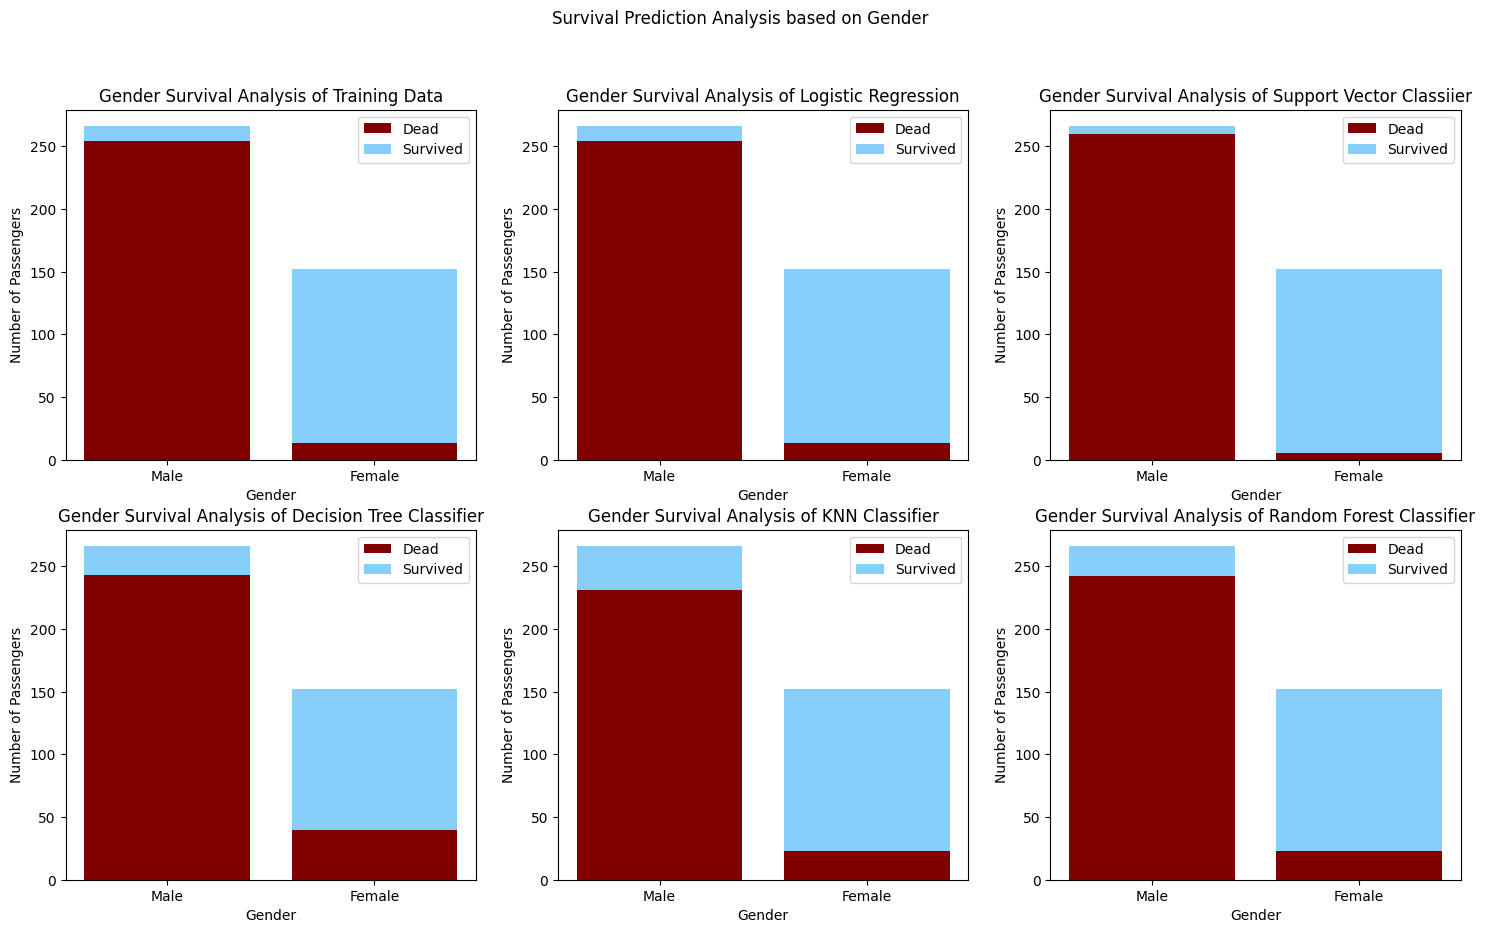

In [31]:
labels = ['Male', 'Female']
fig, ax = plt.subplots(2,3, figsize=(18,10))

ax[0,0].bar(labels, df_test[df_test['Preds1'] == 0]['Sex'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,0].bar(labels, df_test[df_test['Preds1'] == 1]['Sex'].value_counts().sort_index(), bottom=df_test[df_test['Preds1'] == 0]['Sex'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,0].set_xlabel('Gender')
ax[0,0].set_ylabel('Number of Passengers')
ax[0,0].set_title('Gender Survival Analysis of Training Data')
ax[0,0].legend()

ax[0,1].bar(labels, df_test[df_test['Preds1'] == 0]['Sex'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,1].bar(labels, df_test[df_test['Preds1'] == 1]['Sex'].value_counts().sort_index(), bottom=df_test[df_test['Preds1'] == 0]['Sex'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,1].set_xlabel('Gender')
ax[0,1].set_ylabel('Number of Passengers')
ax[0,1].set_title('Gender Survival Analysis of Logistic Regression')
ax[0,1].legend()

ax[0,2].bar(labels, df_test[df_test['Preds2'] == 0]['Sex'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,2].bar(labels, df_test[df_test['Preds2'] == 1]['Sex'].value_counts().sort_index(), bottom=df_test[df_test['Preds2'] == 0]['Sex'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,2].set_xlabel('Gender')
ax[0,2].set_ylabel('Number of Passengers')
ax[0,2].set_title('Gender Survival Analysis of Support Vector Classiier')
ax[0,2].legend()

ax[1,0].bar(labels, df_test[df_test['Preds3'] == 0]['Sex'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,0].bar(labels, df_test[df_test['Preds3'] == 1]['Sex'].value_counts().sort_index(), bottom=df_test[df_test['Preds3'] == 0]['Sex'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,0].set_xlabel('Gender')
ax[1,0].set_ylabel('Number of Passengers')
ax[1,0].set_title('Gender Survival Analysis of Decision Tree Classifier')
ax[1,0].legend()

ax[1,1].bar(labels, df_test[df_test['Preds4'] == 0]['Sex'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,1].bar(labels, df_test[df_test['Preds4'] == 1]['Sex'].value_counts().sort_index(), bottom=df_test[df_test['Preds4'] == 0]['Sex'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,1].set_xlabel('Gender')
ax[1,1].set_ylabel('Number of Passengers')
ax[1,1].set_title('Gender Survival Analysis of KNN Classifier')
ax[1,1].legend()

ax[1,2].bar(labels, df_test[df_test['Preds5'] == 0]['Sex'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,2].bar(labels, df_test[df_test['Preds5'] == 1]['Sex'].value_counts().sort_index(), bottom=df_test[df_test['Preds5'] == 0]['Sex'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,2].set_xlabel('Gender')
ax[1,2].set_ylabel('Number of Passengers')
ax[1,2].set_title('Gender Survival Analysis of Random Forest Classifier')
ax[1,2].legend()

plt.suptitle("Survival Prediction Analysis based on Gender")
plt.savefig('./plots/Gender Survival Analysis.png')
plt.show()

### 4.3. Passenger Class Analysis

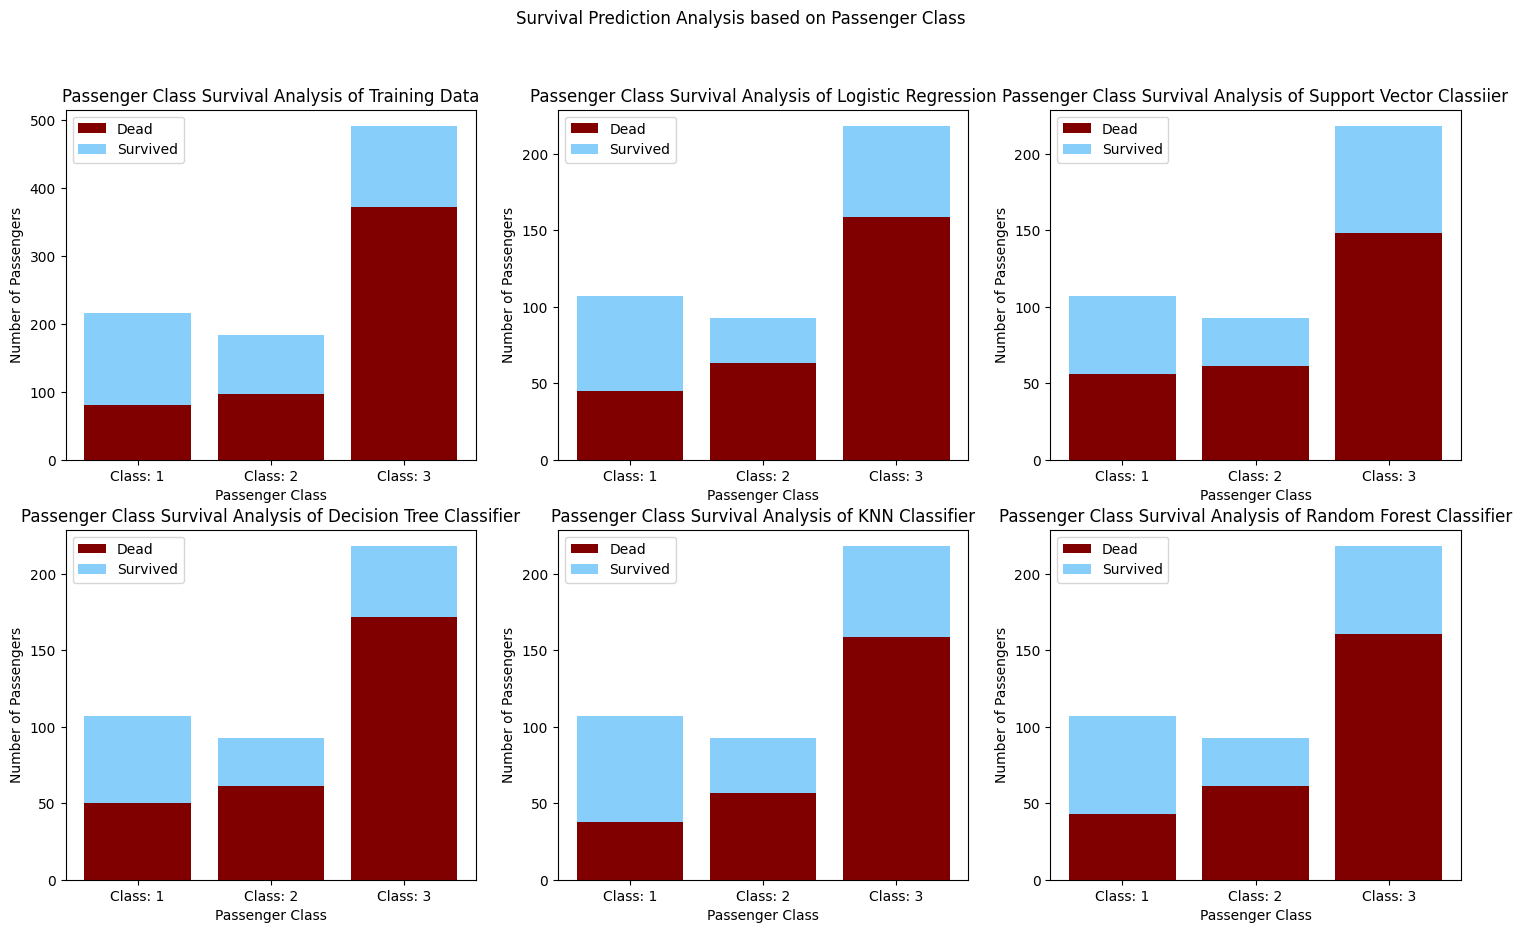

In [32]:
labels = ['Class: 1', 'Class: 2', 'Class: 3']
fig, ax = plt.subplots(2,3, figsize=(18,10))

ax[0,0].bar(labels, df_train[df_train['Survived'] == 0]['Pclass'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,0].bar(labels, df_train[df_train['Survived'] == 1]['Pclass'].value_counts().sort_index(), bottom=df_train[df_train['Survived'] == 0]['Pclass'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,0].set_xlabel('Passenger Class')
ax[0,0].set_ylabel('Number of Passengers')
ax[0,0].set_title('Passenger Class Survival Analysis of Training Data')
ax[0,0].legend()

ax[0,1].bar(labels, df_test[df_test['Preds1'] == 0]['Pclass'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,1].bar(labels, df_test[df_test['Preds1'] == 1]['Pclass'].value_counts().sort_index(), bottom=df_test[df_test['Preds1'] == 0]['Pclass'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,1].set_xlabel('Passenger Class')
ax[0,1].set_ylabel('Number of Passengers')
ax[0,1].set_title('Passenger Class Survival Analysis of Logistic Regression')
ax[0,1].legend()

ax[0,2].bar(labels, df_test[df_test['Preds2'] == 0]['Pclass'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,2].bar(labels, df_test[df_test['Preds2'] == 1]['Pclass'].value_counts().sort_index(), bottom=df_test[df_test['Preds2'] == 0]['Pclass'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,2].set_xlabel('Passenger Class')
ax[0,2].set_ylabel('Number of Passengers')
ax[0,2].set_title('Passenger Class Survival Analysis of Support Vector Classiier')
ax[0,2].legend()

ax[1,0].bar(labels, df_test[df_test['Preds3'] == 0]['Pclass'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,0].bar(labels, df_test[df_test['Preds3'] == 1]['Pclass'].value_counts().sort_index(), bottom=df_test[df_test['Preds3'] == 0]['Pclass'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,0].set_xlabel('Passenger Class')
ax[1,0].set_ylabel('Number of Passengers')
ax[1,0].set_title('Passenger Class Survival Analysis of Decision Tree Classifier')
ax[1,0].legend()

ax[1,1].bar(labels, df_test[df_test['Preds4'] == 0]['Pclass'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,1].bar(labels, df_test[df_test['Preds4'] == 1]['Pclass'].value_counts().sort_index(), bottom=df_test[df_test['Preds4'] == 0]['Pclass'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,1].set_xlabel('Passenger Class')
ax[1,1].set_ylabel('Number of Passengers')
ax[1,1].set_title('Passenger Class Survival Analysis of KNN Classifier')
ax[1,1].legend()

ax[1,2].bar(labels, df_test[df_test['Preds5'] == 0]['Pclass'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,2].bar(labels, df_test[df_test['Preds5'] == 1]['Pclass'].value_counts().sort_index(), bottom=df_test[df_test['Preds5'] == 0]['Pclass'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,2].set_xlabel('Passenger Class')
ax[1,2].set_ylabel('Number of Passengers')
ax[1,2].set_title('Passenger Class Survival Analysis of Random Forest Classifier')
ax[1,2].legend()

plt.suptitle("Survival Prediction Analysis based on Passenger Class")
plt.savefig('./plots/Passenger Class Survival Analysis.png')
plt.show()

### 4.4. Embarkment Port Analysis

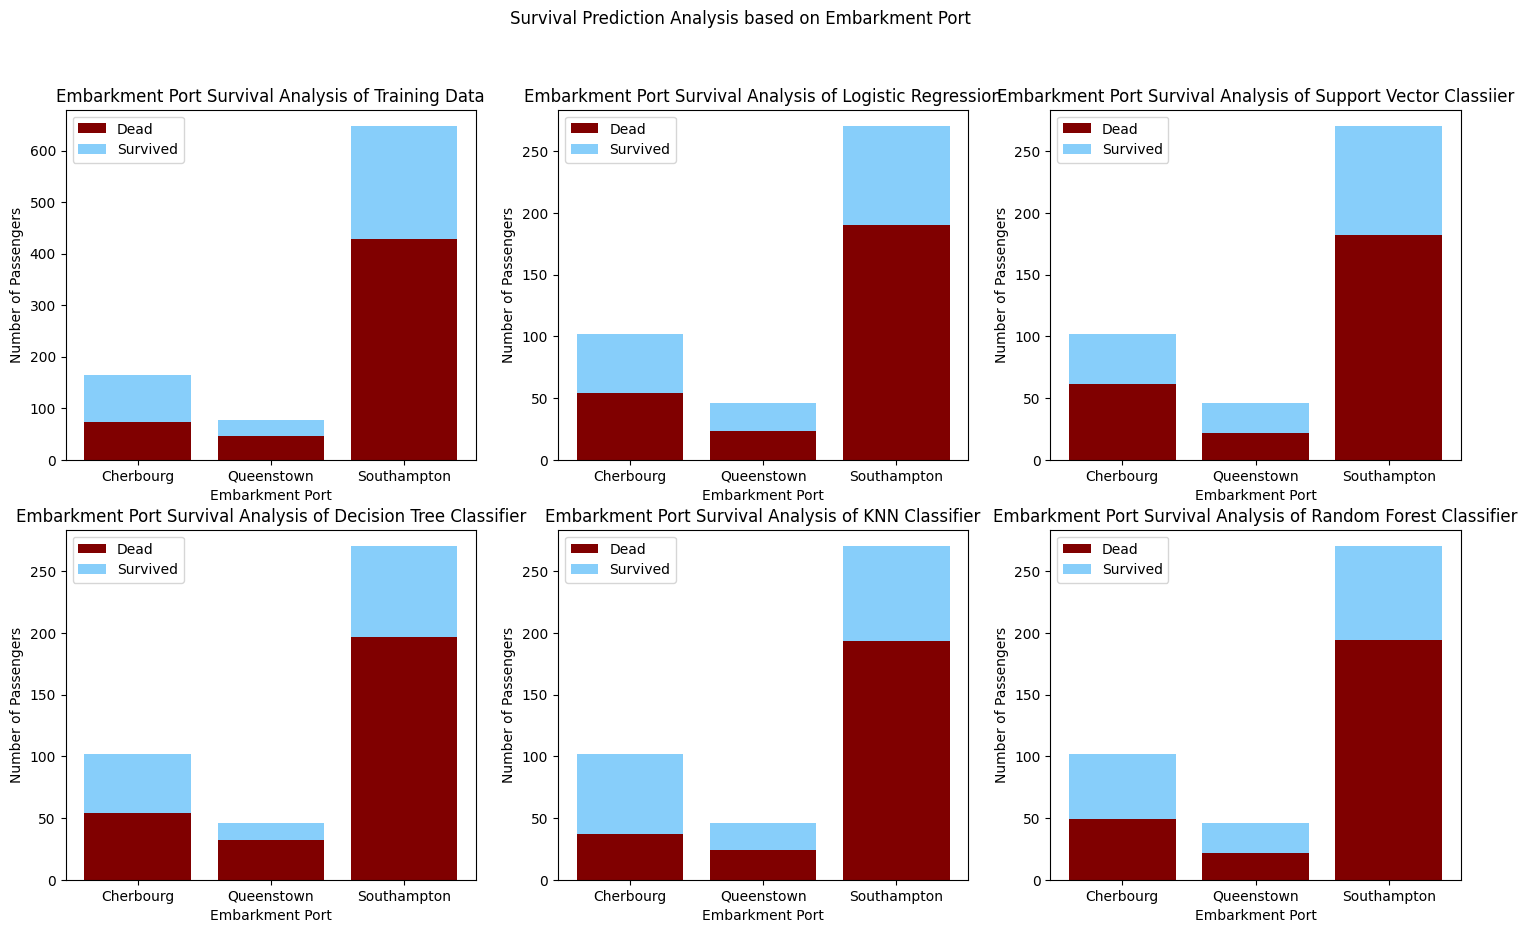

In [33]:
labels = ['Cherbourg', 'Queenstown', 'Southampton']
fig, ax = plt.subplots(2,3, figsize=(18,10))

ax[0,0].bar(labels, df_train[df_train['Survived'] == 0]['Embarked'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,0].bar(labels, df_train[df_train['Survived'] == 1]['Embarked'].value_counts().sort_index()[1:], bottom=df_train[df_train['Survived'] == 0]['Embarked'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,0].set_xlabel('Embarkment Port')
ax[0,0].set_ylabel('Number of Passengers')
ax[0,0].set_title('Embarkment Port Survival Analysis of Training Data')
ax[0,0].legend()

ax[0,1].bar(labels, df_test[df_test['Preds1'] == 0]['Embarked'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,1].bar(labels, df_test[df_test['Preds1'] == 1]['Embarked'].value_counts().sort_index(), bottom=df_test[df_test['Preds1'] == 0]['Embarked'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,1].set_xlabel('Embarkment Port')
ax[0,1].set_ylabel('Number of Passengers')
ax[0,1].set_title('Embarkment Port Survival Analysis of Logistic Regression')
ax[0,1].legend()

ax[0,2].bar(labels, df_test[df_test['Preds2'] == 0]['Embarked'].value_counts().sort_index() , label='Dead', color='maroon')
ax[0,2].bar(labels, df_test[df_test['Preds2'] == 1]['Embarked'].value_counts().sort_index(), bottom=df_test[df_test['Preds2'] == 0]['Embarked'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[0,2].set_xlabel('Embarkment Port')
ax[0,2].set_ylabel('Number of Passengers')
ax[0,2].set_title('Embarkment Port Survival Analysis of Support Vector Classiier')
ax[0,2].legend()

ax[1,0].bar(labels, df_test[df_test['Preds3'] == 0]['Embarked'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,0].bar(labels, df_test[df_test['Preds3'] == 1]['Embarked'].value_counts().sort_index(), bottom=df_test[df_test['Preds3'] == 0]['Embarked'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,0].set_xlabel('Embarkment Port')
ax[1,0].set_ylabel('Number of Passengers')
ax[1,0].set_title('Embarkment Port Survival Analysis of Decision Tree Classifier')
ax[1,0].legend()

ax[1,1].bar(labels, df_test[df_test['Preds4'] == 0]['Embarked'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,1].bar(labels, df_test[df_test['Preds4'] == 1]['Embarked'].value_counts().sort_index(), bottom=df_test[df_test['Preds4'] == 0]['Embarked'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,1].set_xlabel('Embarkment Port')
ax[1,1].set_ylabel('Number of Passengers')
ax[1,1].set_title('Embarkment Port Survival Analysis of KNN Classifier')
ax[1,1].legend()

ax[1,2].bar(labels, df_test[df_test['Preds5'] == 0]['Embarked'].value_counts().sort_index() , label='Dead', color='maroon')
ax[1,2].bar(labels, df_test[df_test['Preds5'] == 1]['Embarked'].value_counts().sort_index(), bottom=df_test[df_test['Preds5'] == 0]['Embarked'].value_counts().sort_index(), label='Survived', color='lightskyblue')
ax[1,2].set_xlabel('Embarkment Port')
ax[1,2].set_ylabel('Number of Passengers')
ax[1,2].set_title('Embarkment Port Survival Analysis of Random Forest Classifier')
ax[1,2].legend()

plt.suptitle("Survival Prediction Analysis based on Embarkment Port")
plt.savefig('./plots/Embarkment Port Survival Analysis.png')
plt.show()

### 4.5. Survival Analysis Plots

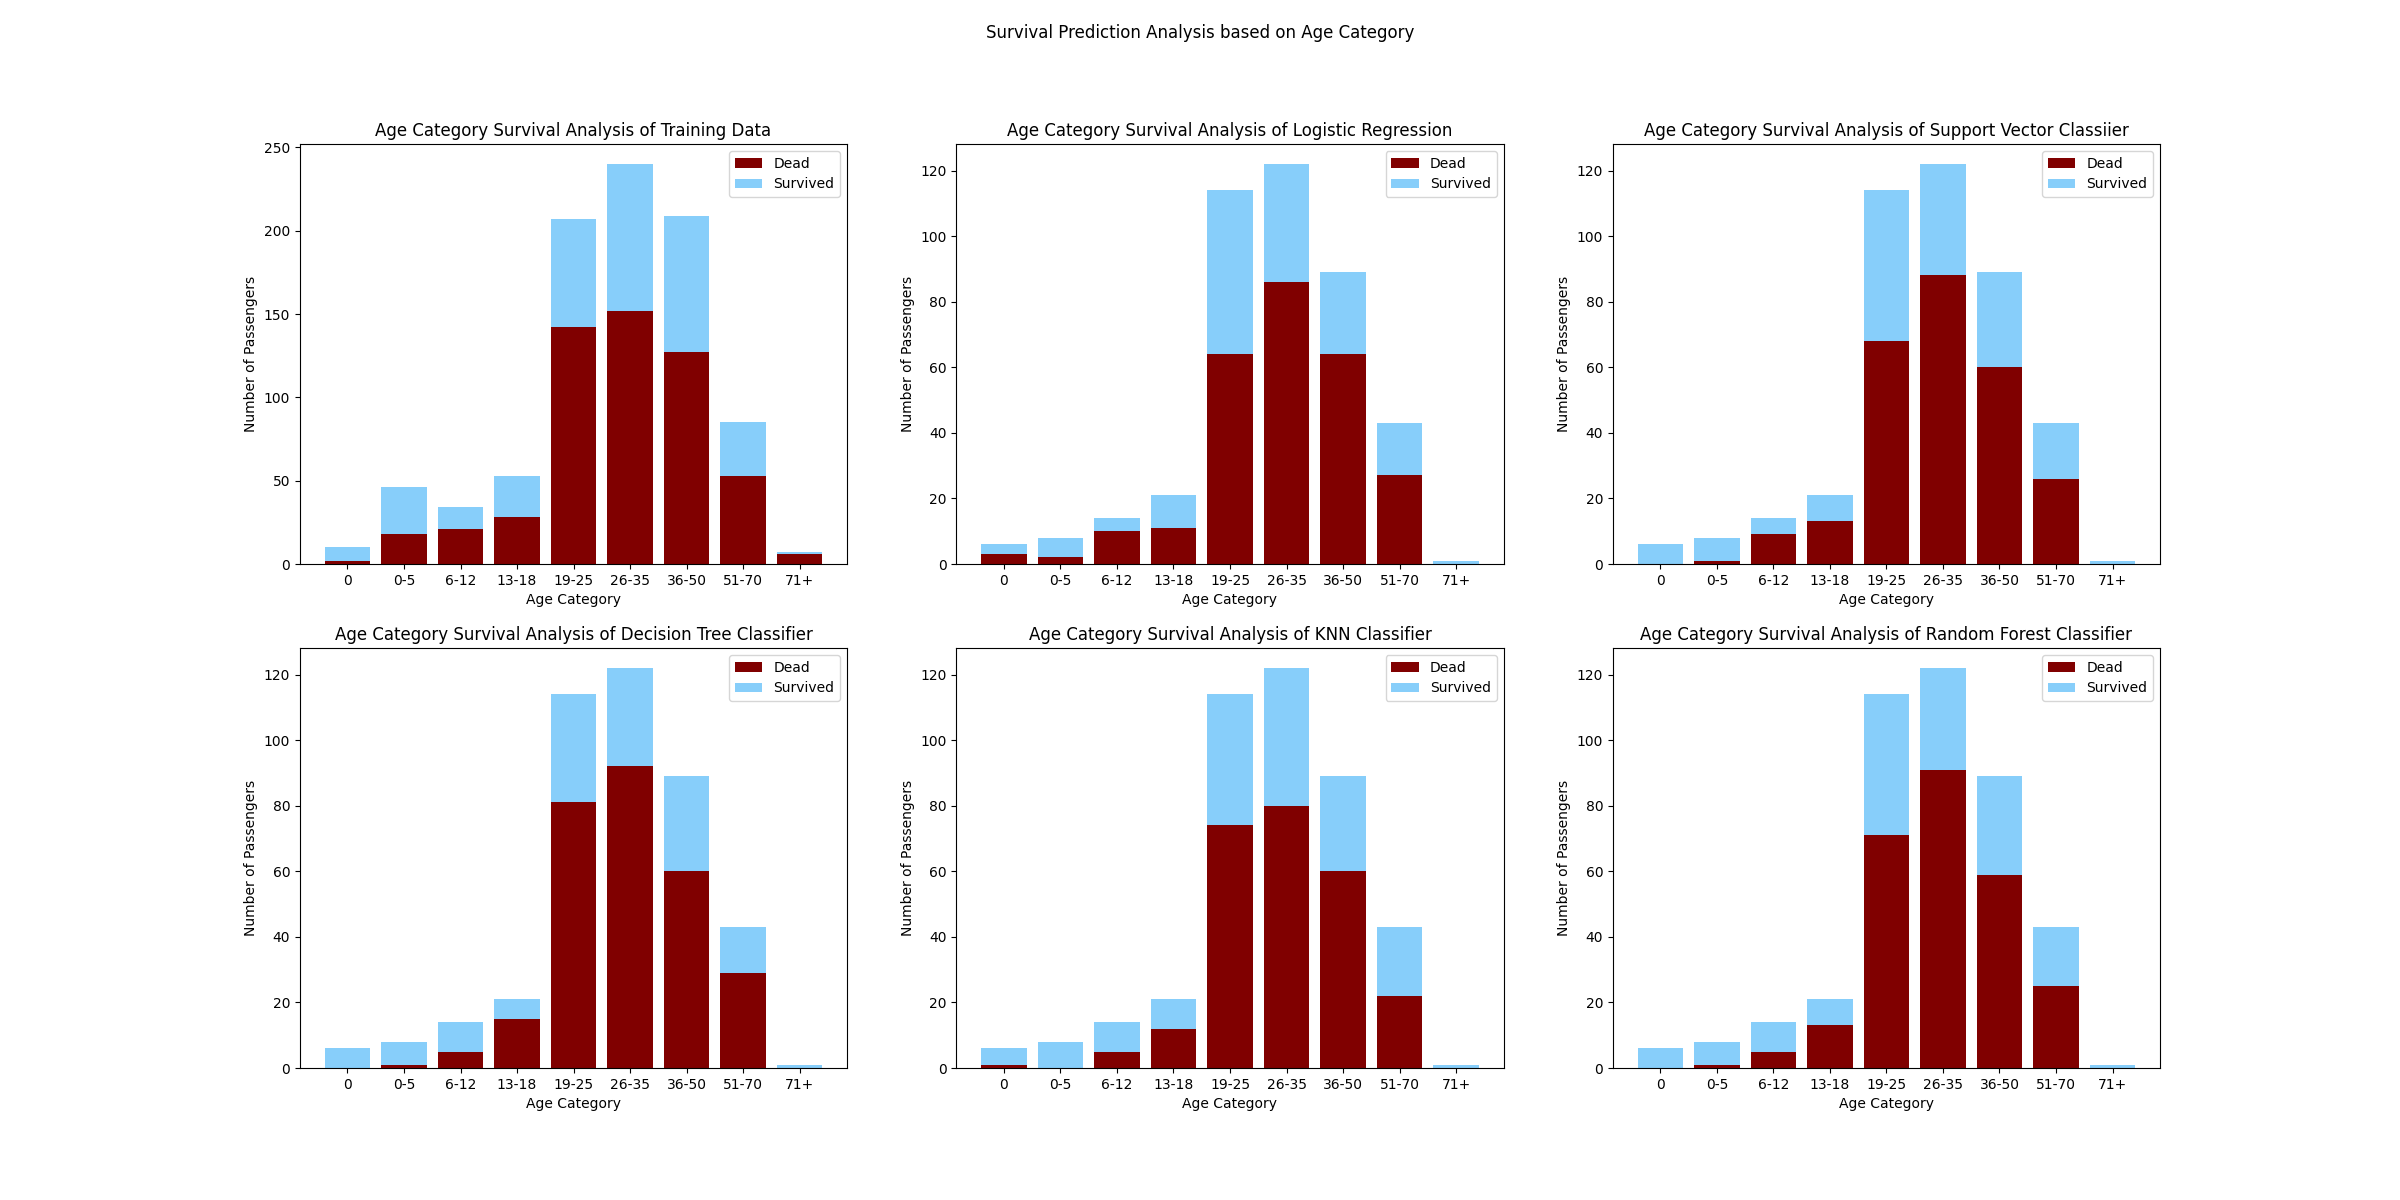

In [34]:
display.Image("./plots/Age Survival Analysis.png")

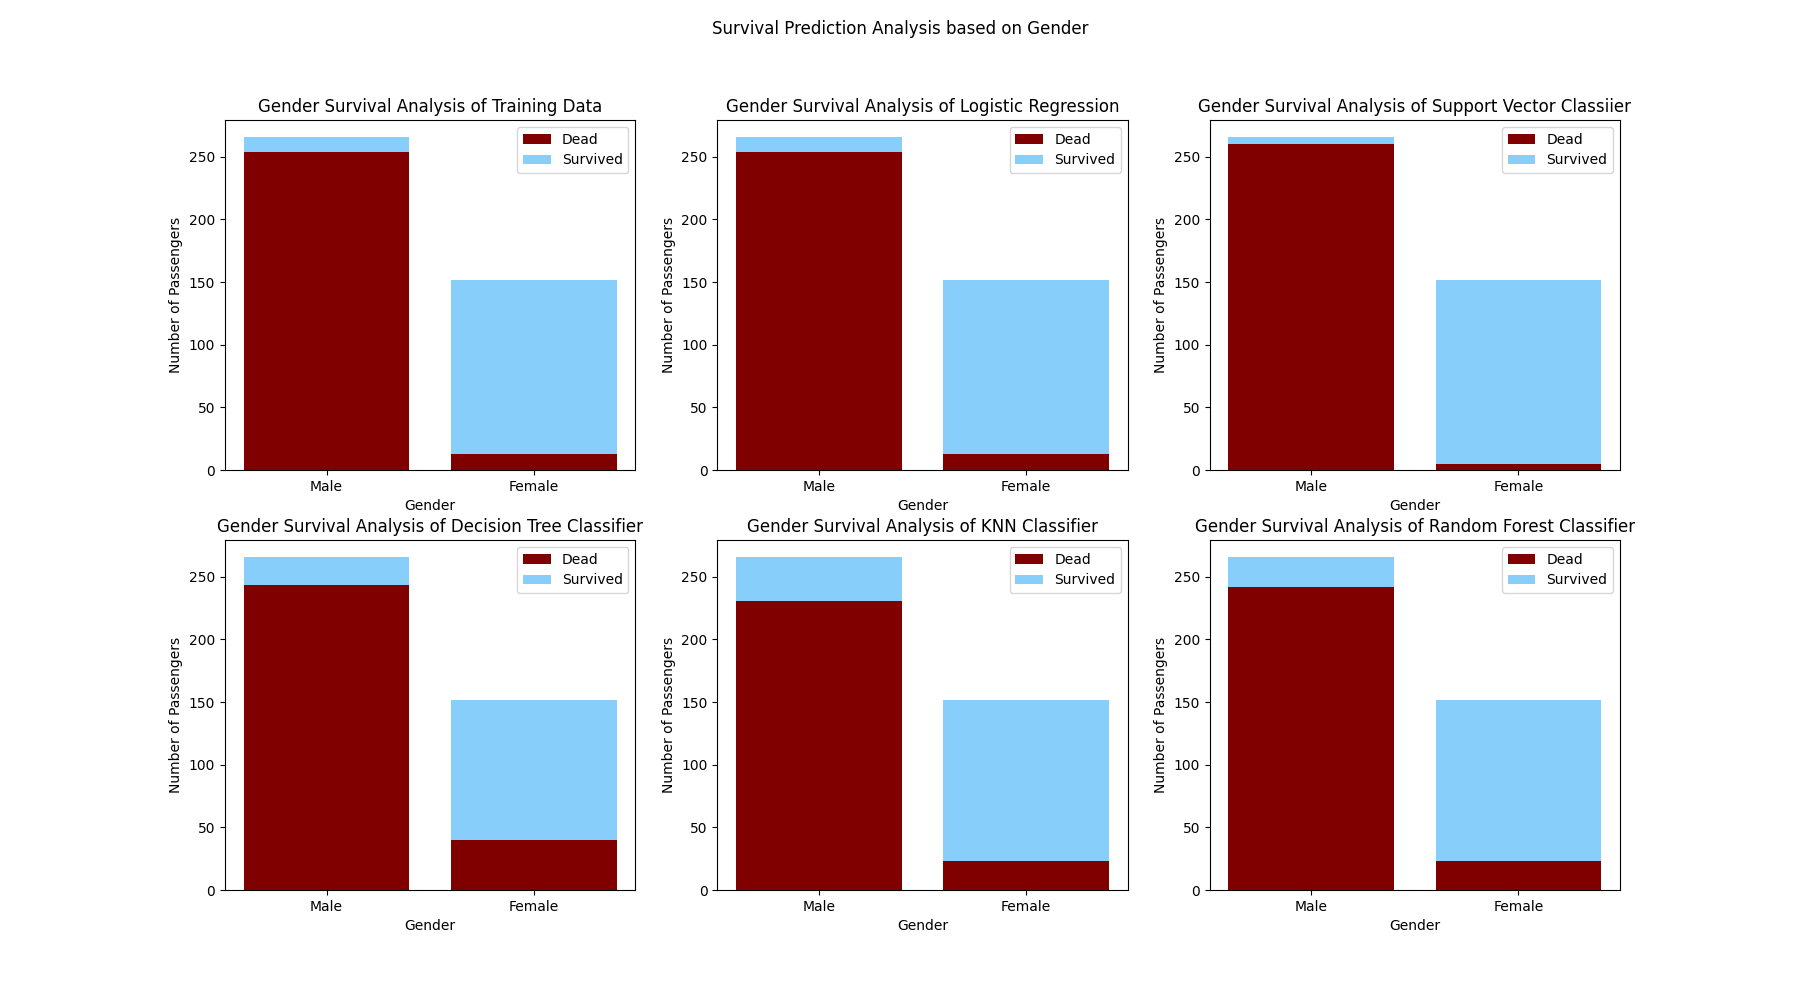

In [35]:
display.Image("./plots/Gender Survival Analysis.png")

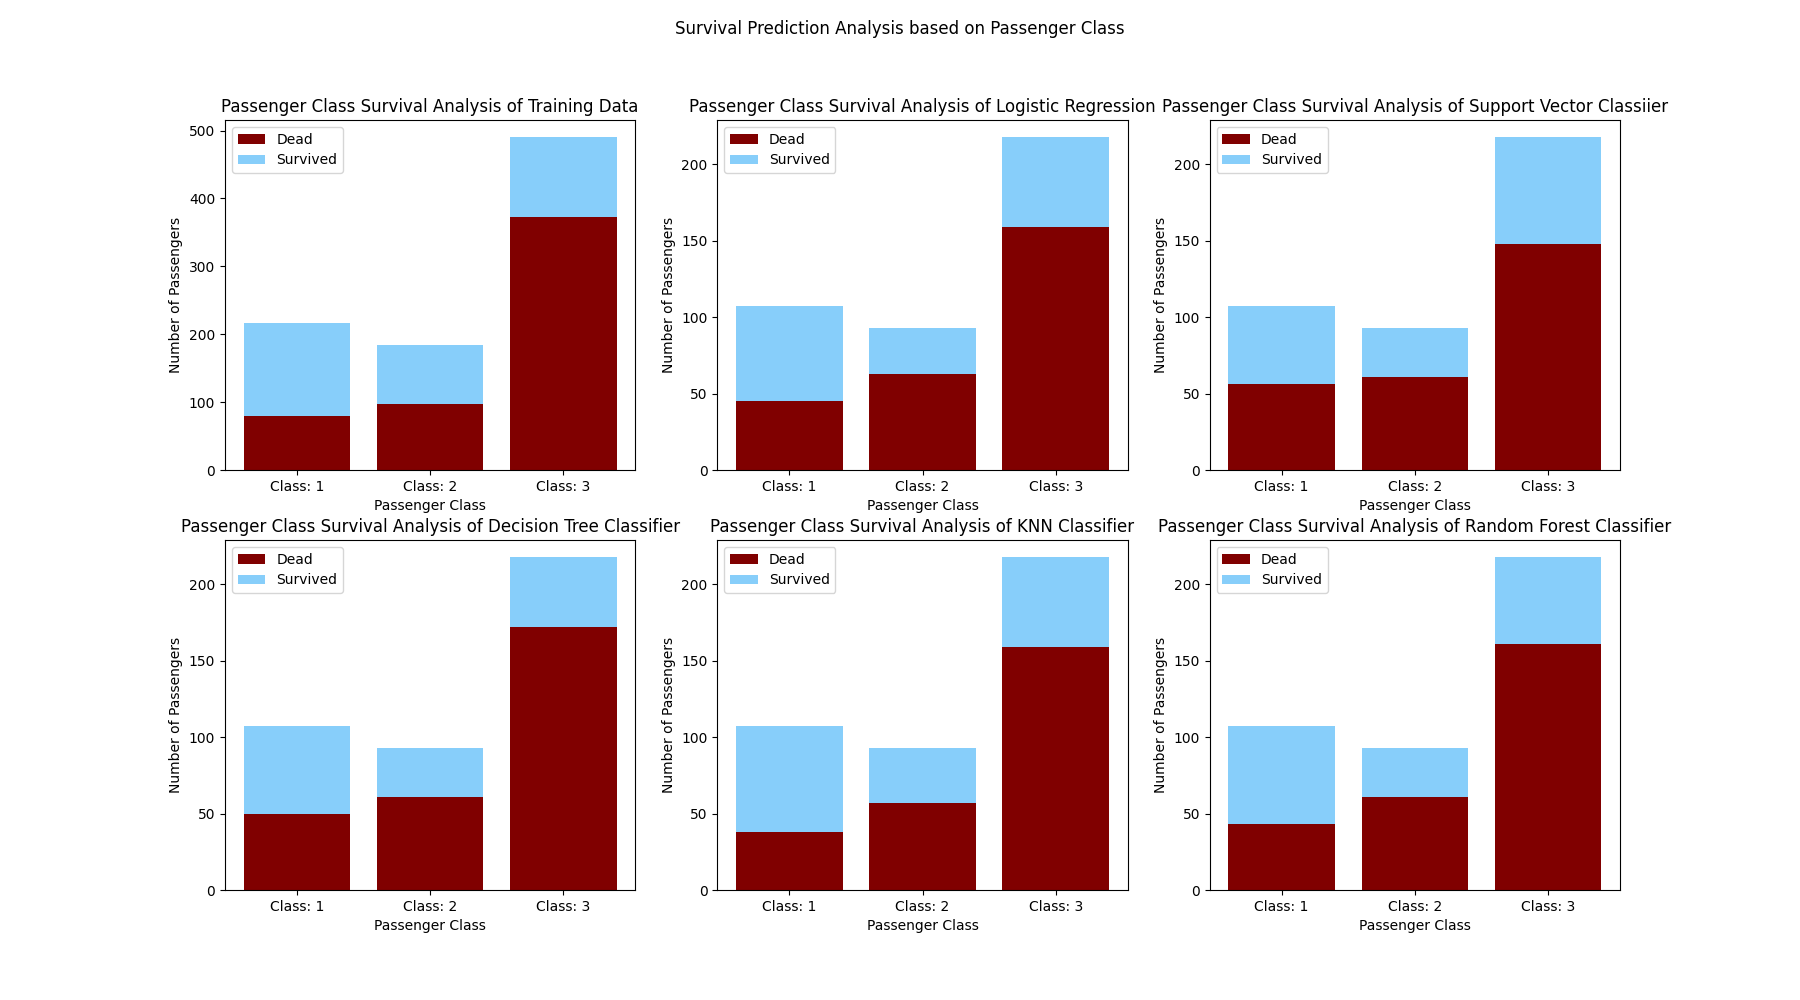

In [36]:
display.Image("./plots/Passenger Class Survival Analysis.png")

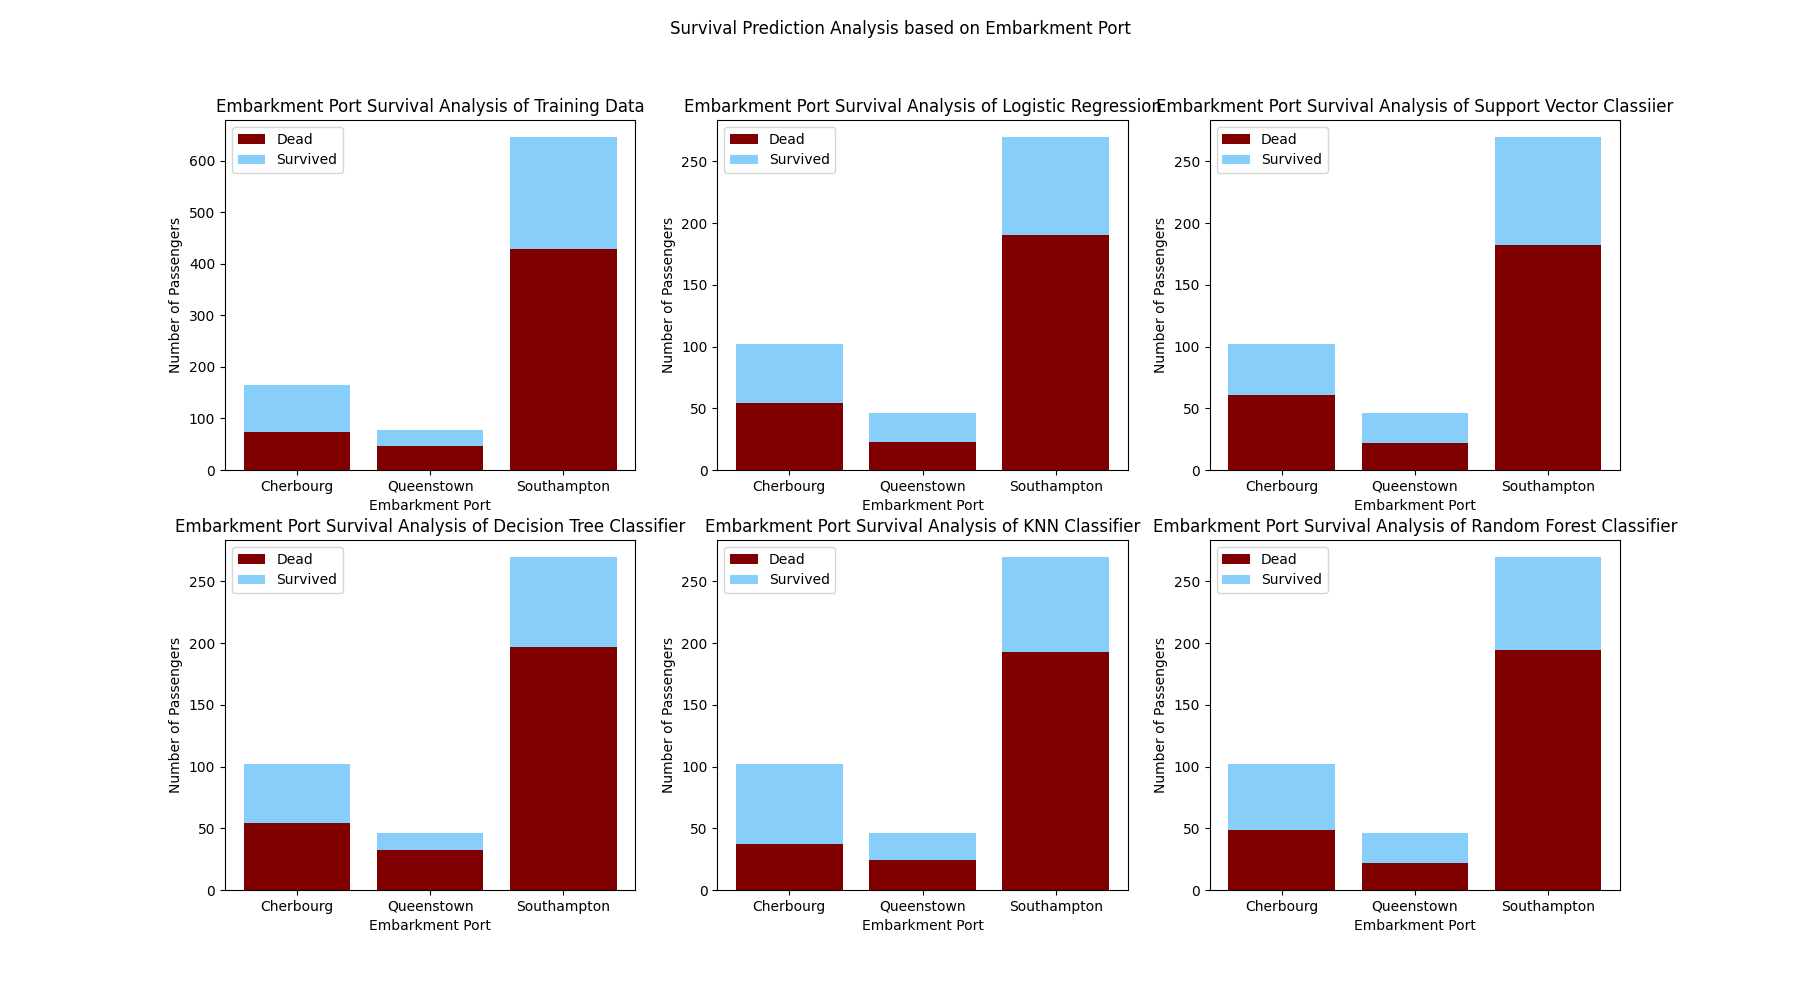

In [37]:
display.Image("./plots/Embarkment Port Survival Analysis.png")